In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

In [2]:
def get_mgrid(sidelen, dim=2, start=0, end=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of start to end, inclusive.
    sidelen: int
    dim: int
    start: int
    end: int'''
    tensors = tuple(dim * [torch.linspace(start, end, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [3]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [4]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [5]:
from modified_siren import Expanded_Siren
from optimizer import EMA_params, perturb_params, shift_loss_params

In [6]:
#cameraman = ImageFitting(256)
#dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

#img_siren = expanded_Siren(in_features=2, out_features=1, hidden_layers = [128, 128, 128, 128], basic=True,
#                           outermost_linear=True)
#hidden_layers = [128, 128, 128, 128, 128, 128, 64, 64]
hidden_layers = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
#hidden_layers = [64, 64, 64, 64]
#hidden_layers = [64, 64, 64, 64, 64, 64]
#hidden_layers = [256, 256, 256, 256]
#hidden_layers = [170, 150, 128, 128]
linear_output = True
img_exp_siren = Expanded_Siren(in_features=2, out_features=1, hidden_layers=hidden_layers,
                           outermost_linear=True, linear_output=linear_output, 
                              linear_output_included = False)
img_exp_siren.cuda()

Expanded_Siren(
  (net): Sequential(
    (0): Expanded_SineLayer(
      (linear): Linear(in_features=2, out_features=64, bias=True)
    )
    (1): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (4): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (5): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (6): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (7): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (8): Expanded_SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (9): Expanded_SineLayer(
      (linear): L

In [7]:
print(img_exp_siren.net)

print("Model's state_dict:")
net = img_exp_siren
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Sequential(
  (0): Expanded_SineLayer(
    (linear): Linear(in_features=2, out_features=64, bias=True)
  )
  (1): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (2): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (3): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (4): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (5): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (6): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (7): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (8): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (9): Expanded_SineLayer(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (10): Expanded_SineLayer(
 

In [8]:
import scipy.ndimage
    
class PoissonEqn(torch.utils.data.IterableDataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        
        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        
        self.coords = self.coords.squeeze()
        self.pixels = self.pixels.squeeze()
        self.grads  = self.grads.squeeze()
        self.laplace= self.laplace.squeeze()
        
        print("coords: ", self.coords.size())
        print("pixels: ", self.pixels.size())
        print("grads: ", self.grads.size())
        print("laplace: ", self.laplace.size())

    def __iter__(self):
        for index in range(256):
            output = (self.coords[256 * index : 256 * (index + 1), :], {
                'pixels':self.pixels[256 * index : 256 * (index + 1)],
                'grads':self.grads[256 * index : 256 * (index + 1), :],
                'laplace':self.laplace[index,:]
            })
            yield output
            
        return
    
    def complete(self):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}
    
batch_size = 32
cameraman_poisson = PoissonEqn(256)
dataloader = DataLoader(cameraman_poisson, batch_size=batch_size, pin_memory=True, num_workers=0)

coords:  torch.Size([65536, 2])
pixels:  torch.Size([65536])
grads:  torch.Size([65536, 2])
laplace:  torch.Size([256, 256])


In [9]:
def total_mse(gt, stan, grad, lapl):
    loss1 = F.mse_loss(stan,    gt['pixels'])     if stan is not None else 0.
    loss2 = F.mse_loss(grad,    gt['grads'])      if grad is not None else 0.
    loss3 = F.mse_loss(lapl,    gt['laplace'])    if lapl is not None else 0.
    return loss1, loss2, loss3

complete_model_input:  torch.Size([65536, 2])
complete_ground_truth[ pixels ]:  torch.Size([65536])
complete_ground_truth[ grads ]:  torch.Size([65536, 2])
complete_ground_truth[ laplace ]:  torch.Size([256, 256])


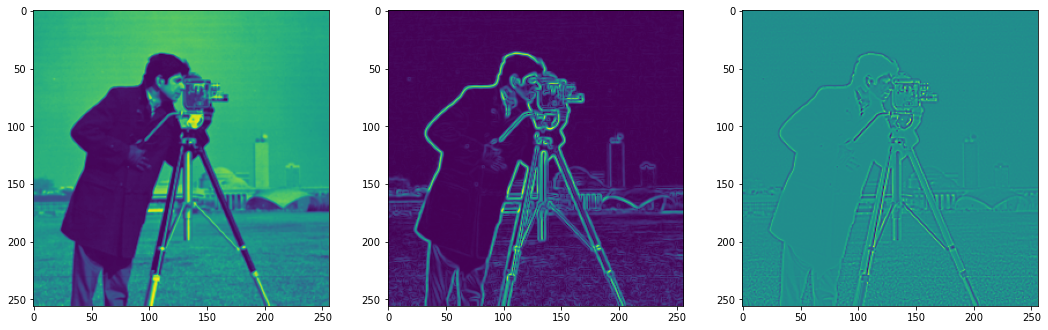

Step: 0
LOSS{true_stan: 1.889385, weighted_stan: 1.889385}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1279377297.250000, weighted_linear: 1279377297.250000}
LOSS{true_total: 1279377280.000000, weighted_total: 1279377280.000000}


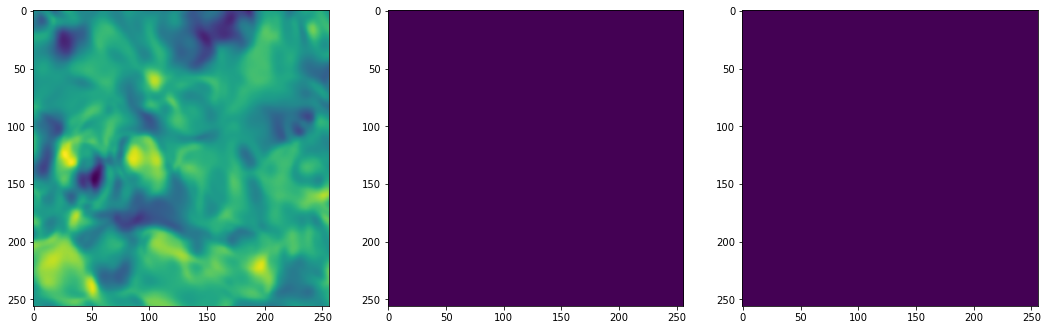

Step: 100
LOSS{true_stan: 0.164760, weighted_stan: 0.164760}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1327815122.500000, weighted_linear: 1327815122.500000}
LOSS{true_total: 1327815168.000000, weighted_total: 1327815168.000000}


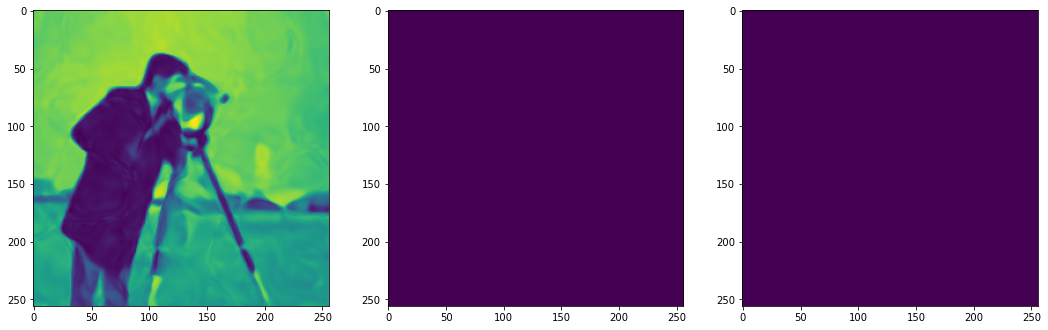

Step: 200
LOSS{true_stan: 0.107387, weighted_stan: 0.107387}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1333976542.250000, weighted_linear: 1333976542.250000}
LOSS{true_total: 1333976576.000000, weighted_total: 1333976576.000000}


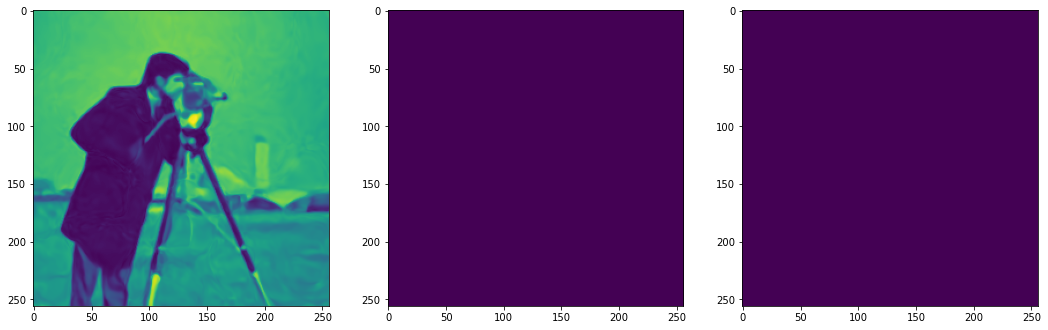

Step: 300
LOSS{true_stan: 0.086493, weighted_stan: 0.086493}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1339133879.000000, weighted_linear: 1339133879.000000}
LOSS{true_total: 1339133824.000000, weighted_total: 1339133824.000000}


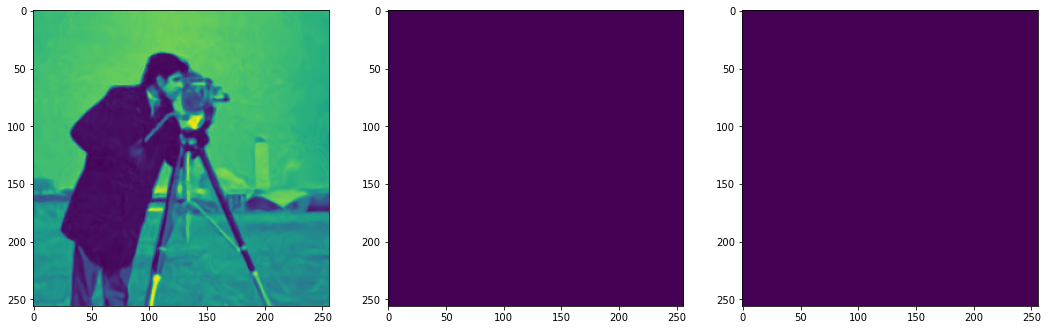

Step: 400
LOSS{true_stan: 0.075594, weighted_stan: 0.075594}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1343827168.000000, weighted_linear: 1343827168.000000}
LOSS{true_total: 1343827200.000000, weighted_total: 1343827200.000000}


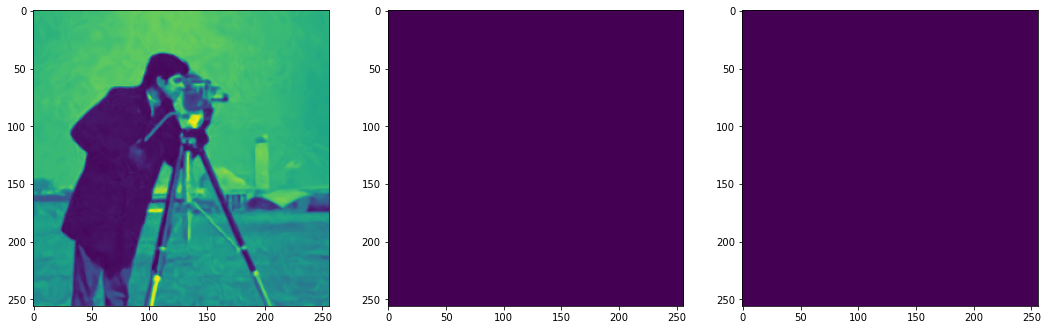

Step: 500
LOSS{true_stan: 0.085567, weighted_stan: 0.085567}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1377078160.250000, weighted_linear: 1377078160.250000}
LOSS{true_total: 1377078144.000000, weighted_total: 1377078144.000000}


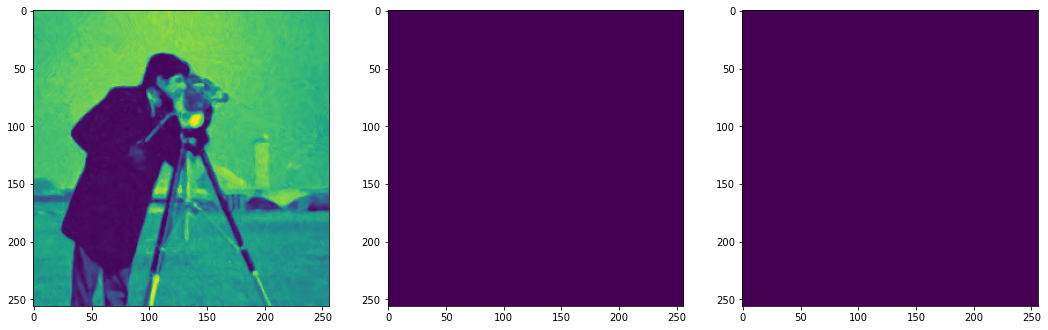

Step: 600
LOSS{true_stan: 0.065152, weighted_stan: 0.065152}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1378264290.500000, weighted_linear: 1378264290.500000}
LOSS{true_total: 1378264320.000000, weighted_total: 1378264320.000000}


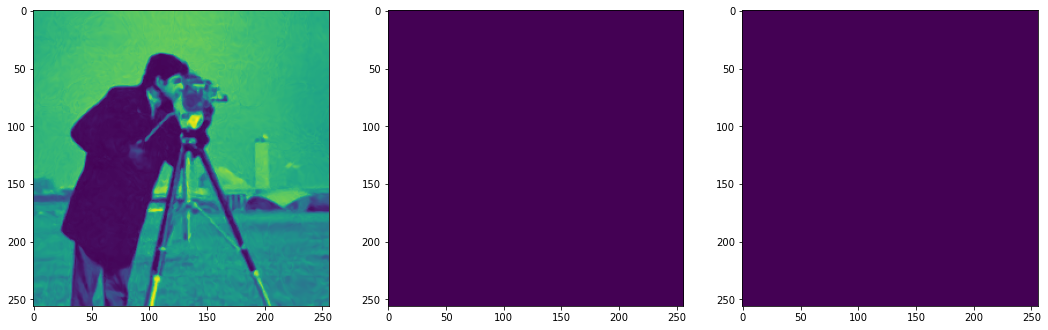

Step: 700
LOSS{true_stan: 0.073552, weighted_stan: 0.073552}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1379527908.750000, weighted_linear: 1379527908.750000}
LOSS{true_total: 1379527936.000000, weighted_total: 1379527936.000000}


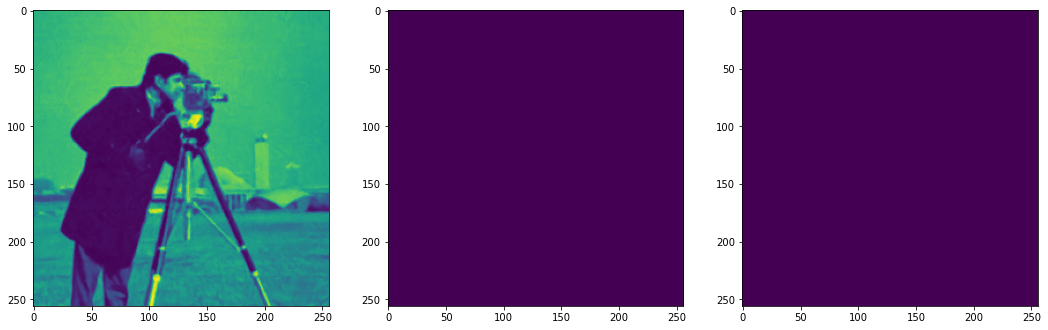

Step: 800
LOSS{true_stan: 0.058803, weighted_stan: 0.058803}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1381054299.250000, weighted_linear: 1381054299.250000}
LOSS{true_total: 1381054336.000000, weighted_total: 1381054336.000000}


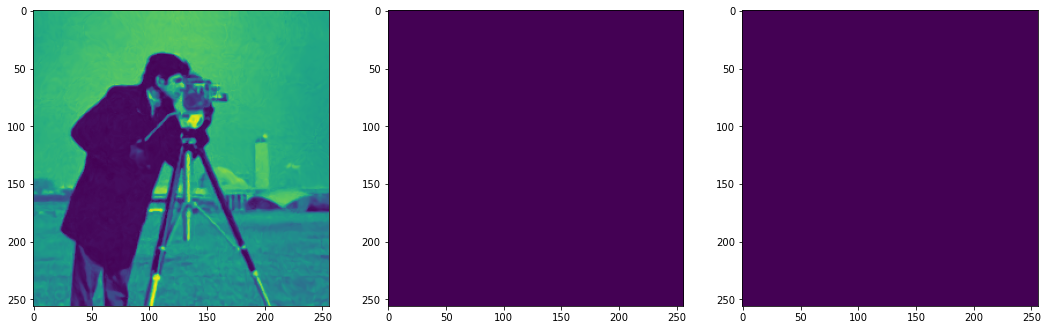

Step: 900
LOSS{true_stan: 0.060774, weighted_stan: 0.060774}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1382821151.500000, weighted_linear: 1382821151.500000}
LOSS{true_total: 1382821120.000000, weighted_total: 1382821120.000000}


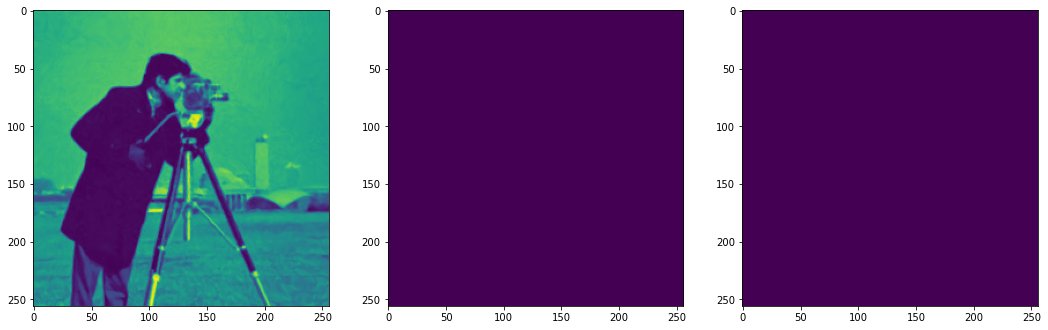

Step: 1000
LOSS{true_stan: 0.058816, weighted_stan: 0.058816}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1385180505.500000, weighted_linear: 1385180505.500000}
LOSS{true_total: 1385180544.000000, weighted_total: 1385180544.000000}


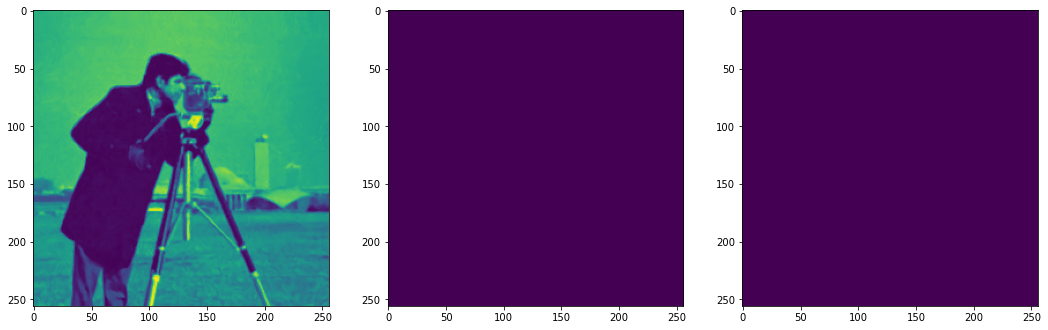

Step: 1100
LOSS{true_stan: 0.067522, weighted_stan: 0.067522}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1389002226.750000, weighted_linear: 1389002226.750000}
LOSS{true_total: 1389002240.000000, weighted_total: 1389002240.000000}


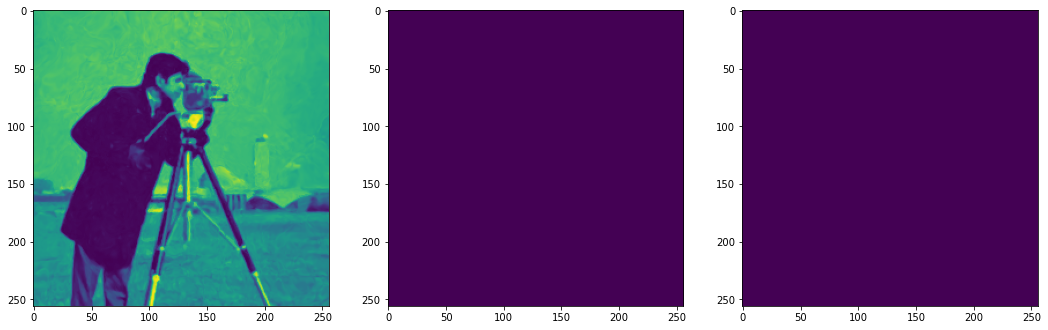

Step: 1200
LOSS{true_stan: 0.041130, weighted_stan: 0.041130}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1391267311.750000, weighted_linear: 1391267311.750000}
LOSS{true_total: 1391267328.000000, weighted_total: 1391267328.000000}


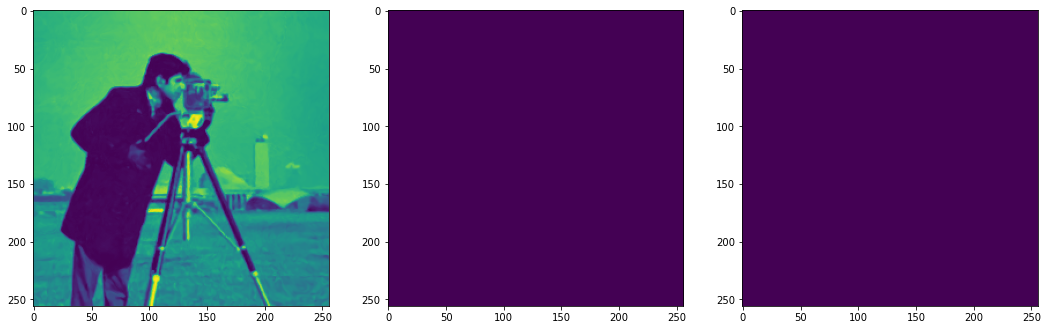

Step: 1300
LOSS{true_stan: 0.057236, weighted_stan: 0.057236}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1391768541.000000, weighted_linear: 1391768541.000000}
LOSS{true_total: 1391768576.000000, weighted_total: 1391768576.000000}


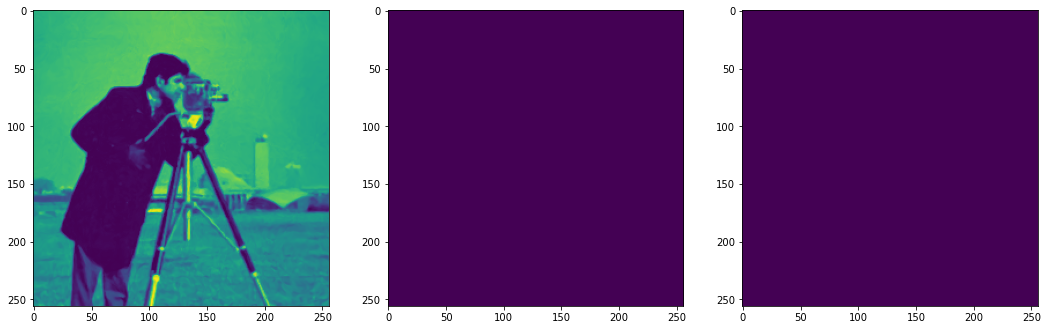

Step: 1400
LOSS{true_stan: 0.034984, weighted_stan: 0.034984}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1395118458.500000, weighted_linear: 1395118458.500000}
LOSS{true_total: 1395118464.000000, weighted_total: 1395118464.000000}


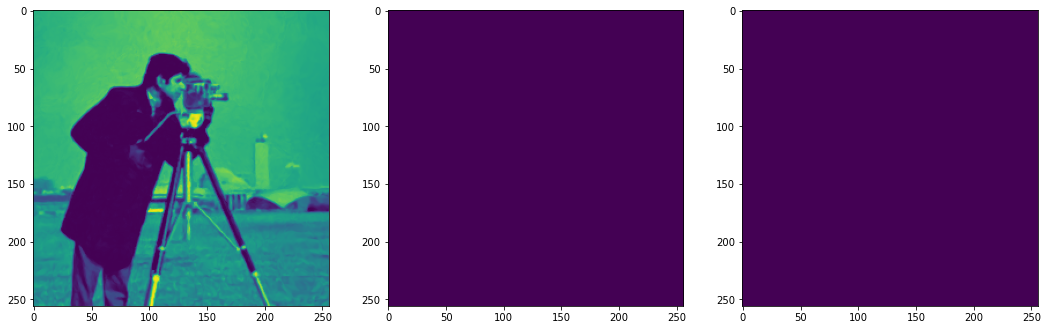

Step: 1500
LOSS{true_stan: 0.030276, weighted_stan: 0.030276}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1395821354.250000, weighted_linear: 1395821354.250000}
LOSS{true_total: 1395821312.000000, weighted_total: 1395821312.000000}


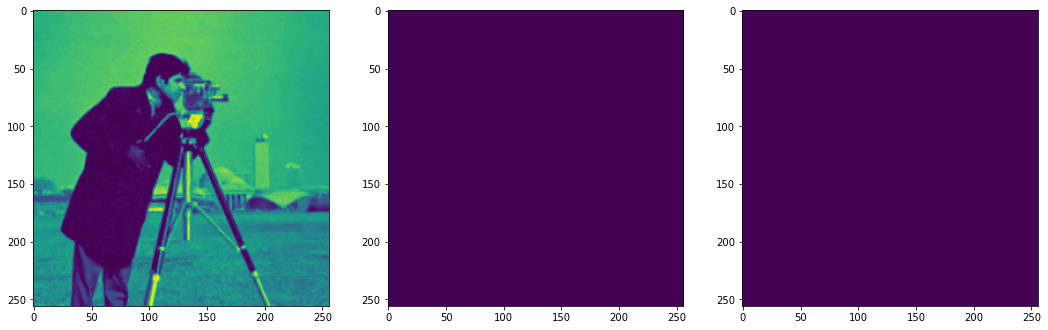

Step: 1600
LOSS{true_stan: 0.039025, weighted_stan: 0.039025}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1396175567.750000, weighted_linear: 1396175567.750000}
LOSS{true_total: 1396175616.000000, weighted_total: 1396175616.000000}


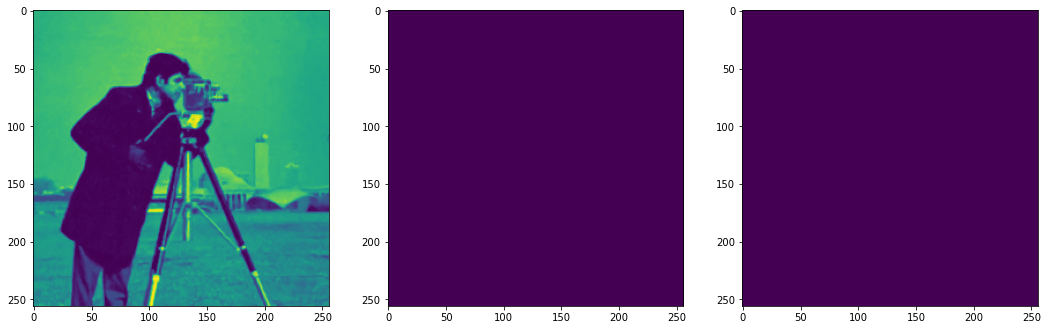

Step: 1700
LOSS{true_stan: 0.041242, weighted_stan: 0.041242}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1396398434.250000, weighted_linear: 1396398434.250000}
LOSS{true_total: 1396398464.000000, weighted_total: 1396398464.000000}


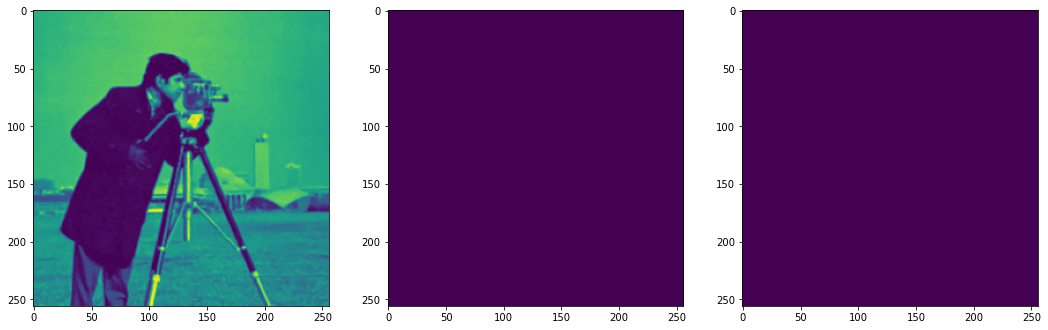

Step: 1800
LOSS{true_stan: 0.037761, weighted_stan: 0.037761}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1411024747.750000, weighted_linear: 1411024747.750000}
LOSS{true_total: 1411024768.000000, weighted_total: 1411024768.000000}


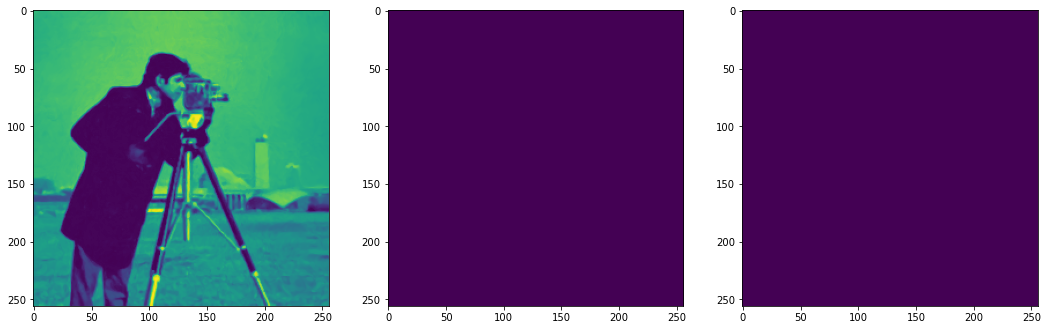

Step: 1900
LOSS{true_stan: 0.032962, weighted_stan: 0.032962}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1410027329.000000, weighted_linear: 1410027329.000000}
LOSS{true_total: 1410027392.000000, weighted_total: 1410027392.000000}


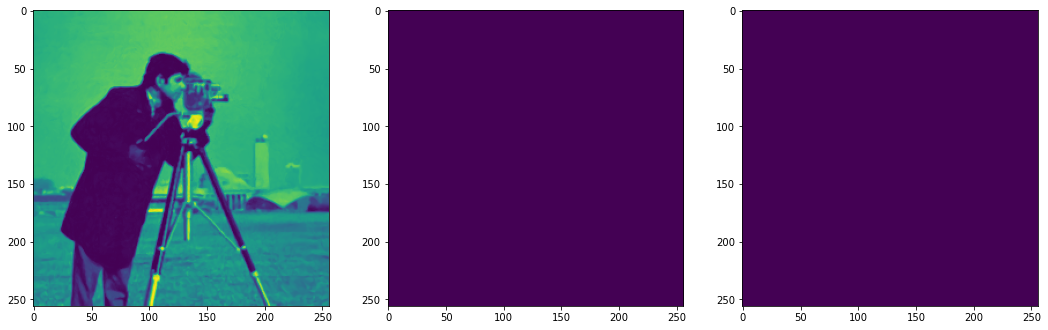

Step: 2000
LOSS{true_stan: 0.039448, weighted_stan: 0.039448}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1408773055.500000, weighted_linear: 1408773055.500000}
LOSS{true_total: 1408772992.000000, weighted_total: 1408772992.000000}


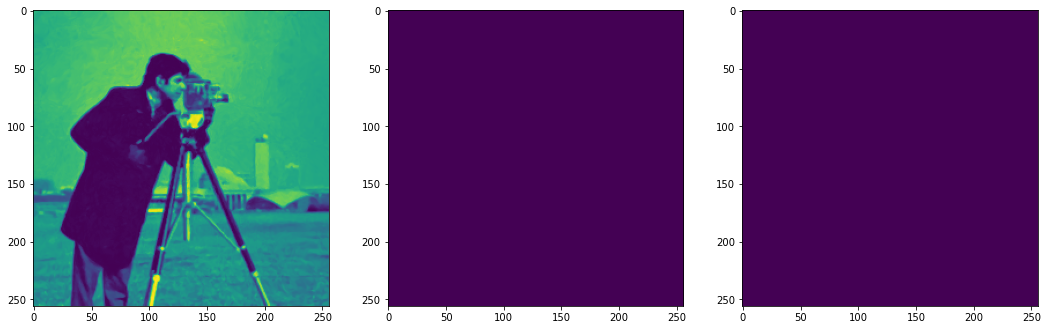

Step: 2100
LOSS{true_stan: 0.037880, weighted_stan: 0.037880}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1411158735.500000, weighted_linear: 1411158735.500000}
LOSS{true_total: 1411158784.000000, weighted_total: 1411158784.000000}


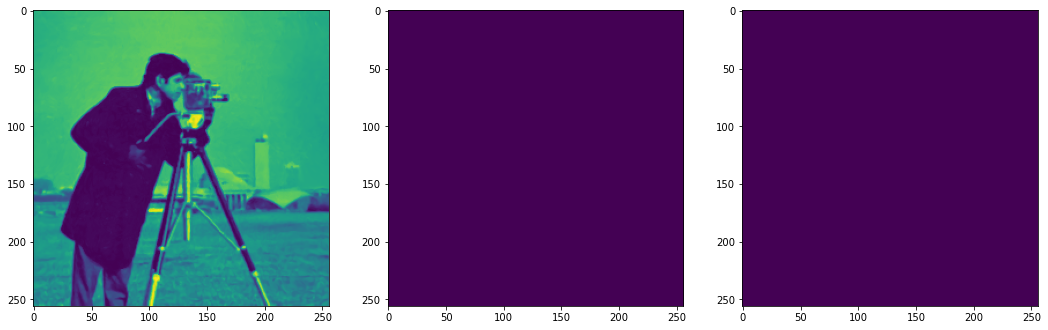

Step: 2200
LOSS{true_stan: 0.041205, weighted_stan: 0.041205}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1420679960.250000, weighted_linear: 1420679960.250000}
LOSS{true_total: 1420679936.000000, weighted_total: 1420679936.000000}


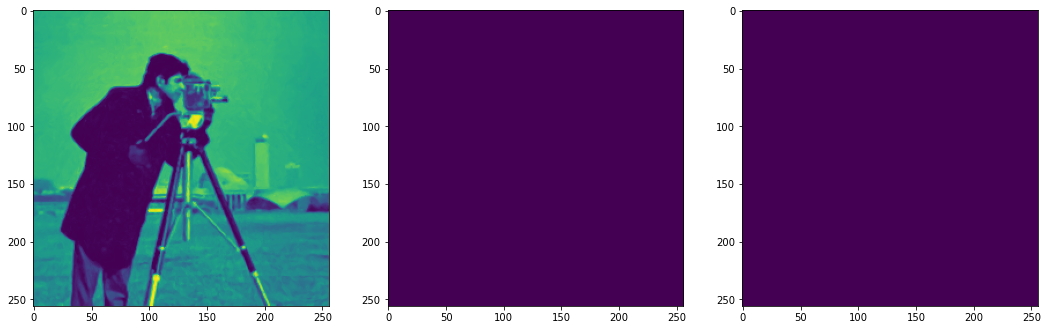

Step: 2300
LOSS{true_stan: 0.016615, weighted_stan: 0.016615}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1421077624.000000, weighted_linear: 1421077624.000000}
LOSS{true_total: 1421077632.000000, weighted_total: 1421077632.000000}


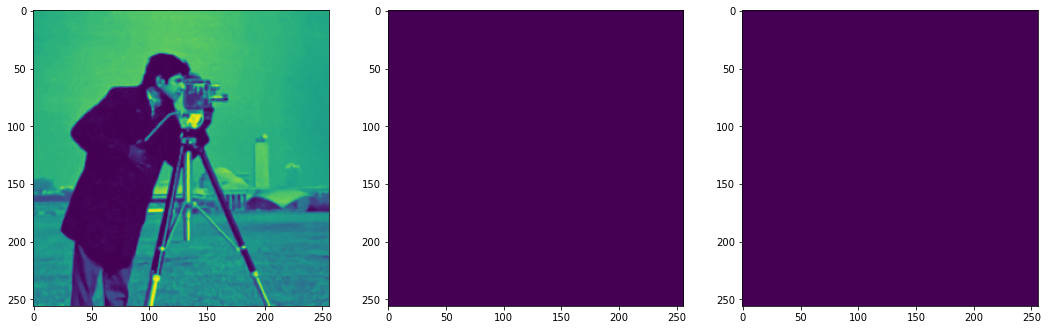

Step: 2400
LOSS{true_stan: 0.025636, weighted_stan: 0.025636}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1423300793.500000, weighted_linear: 1423300793.500000}
LOSS{true_total: 1423300736.000000, weighted_total: 1423300736.000000}


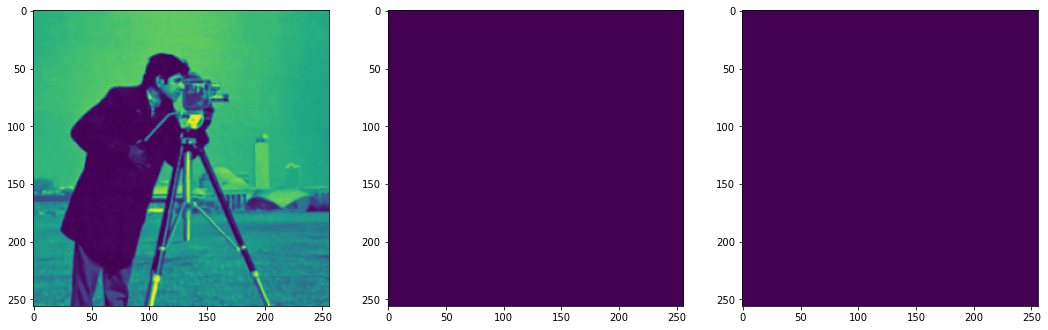

Step: 2500
LOSS{true_stan: 0.030395, weighted_stan: 0.030395}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1423405009.250000, weighted_linear: 1423405009.250000}
LOSS{true_total: 1423405056.000000, weighted_total: 1423405056.000000}


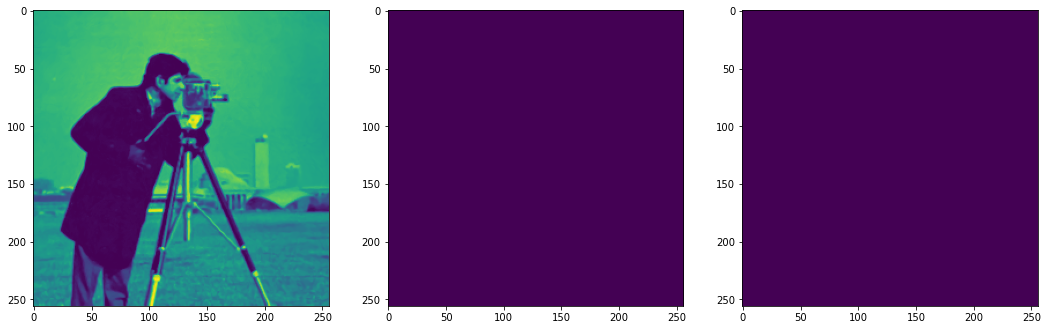

Step: 2600
LOSS{true_stan: 0.052798, weighted_stan: 0.052798}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1437909970.500000, weighted_linear: 1437909970.500000}
LOSS{true_total: 1437910016.000000, weighted_total: 1437910016.000000}


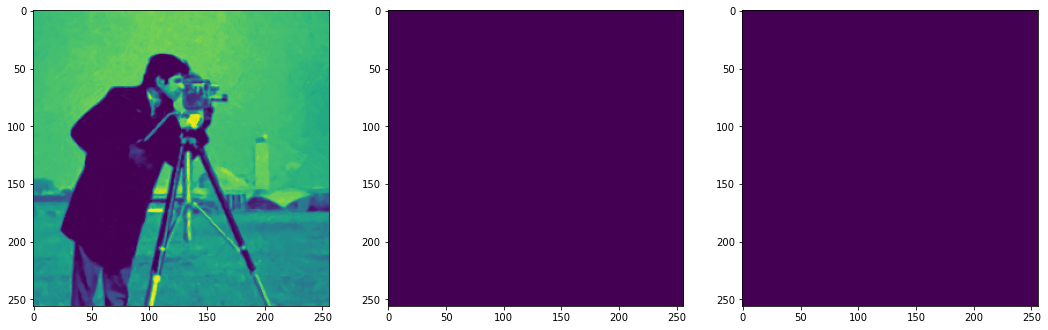

Step: 2700
LOSS{true_stan: 0.034545, weighted_stan: 0.034545}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1435446950.500000, weighted_linear: 1435446950.500000}
LOSS{true_total: 1435446912.000000, weighted_total: 1435446912.000000}


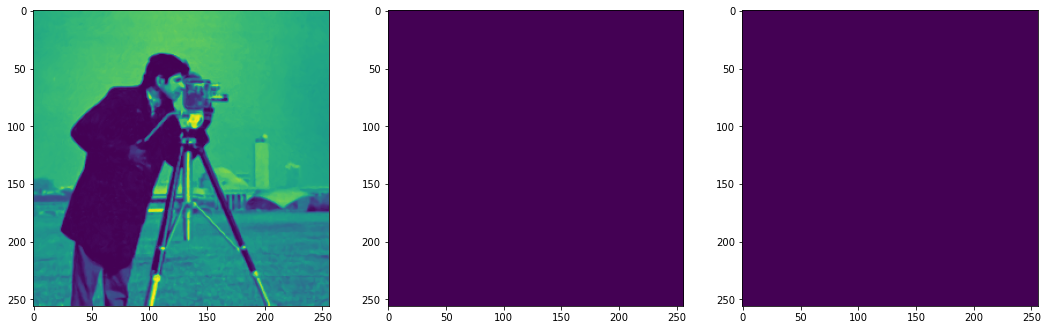

Step: 2800
LOSS{true_stan: 0.027018, weighted_stan: 0.027018}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1435807554.000000, weighted_linear: 1435807554.000000}
LOSS{true_total: 1435807616.000000, weighted_total: 1435807616.000000}


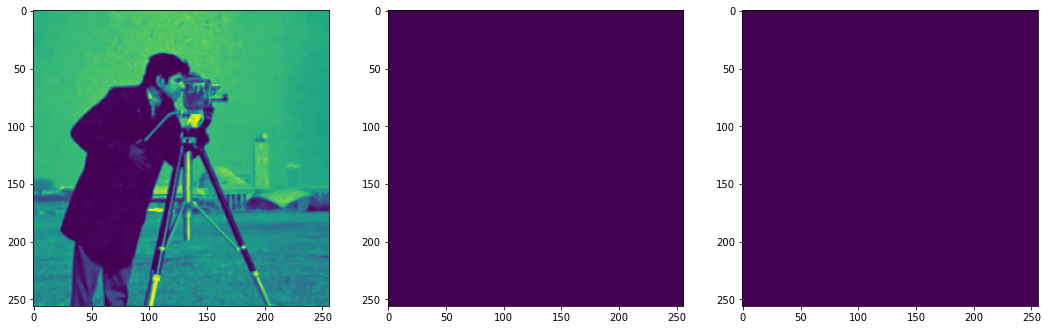

Step: 2900
LOSS{true_stan: 0.031690, weighted_stan: 0.031690}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1437486881.750000, weighted_linear: 1437486881.750000}
LOSS{true_total: 1437486848.000000, weighted_total: 1437486848.000000}


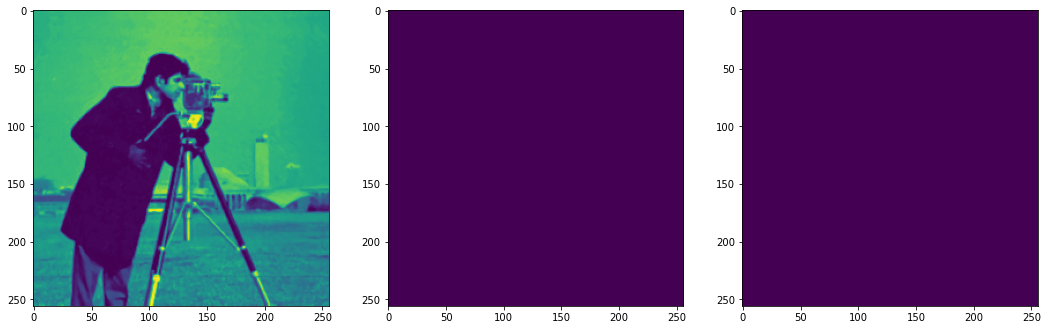

Step: 3000
LOSS{true_stan: 0.034411, weighted_stan: 0.034411}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1440936280.500000, weighted_linear: 1440936280.500000}
LOSS{true_total: 1440936320.000000, weighted_total: 1440936320.000000}


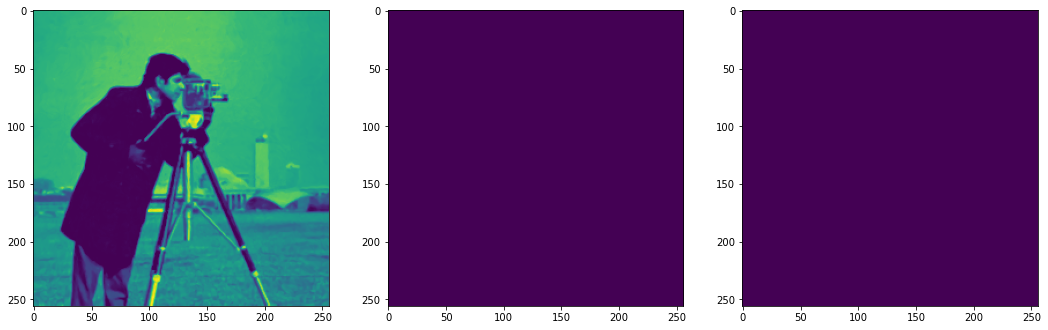

Step: 3100
LOSS{true_stan: 0.028047, weighted_stan: 0.028047}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1441523868.750000, weighted_linear: 1441523868.750000}
LOSS{true_total: 1441523840.000000, weighted_total: 1441523840.000000}


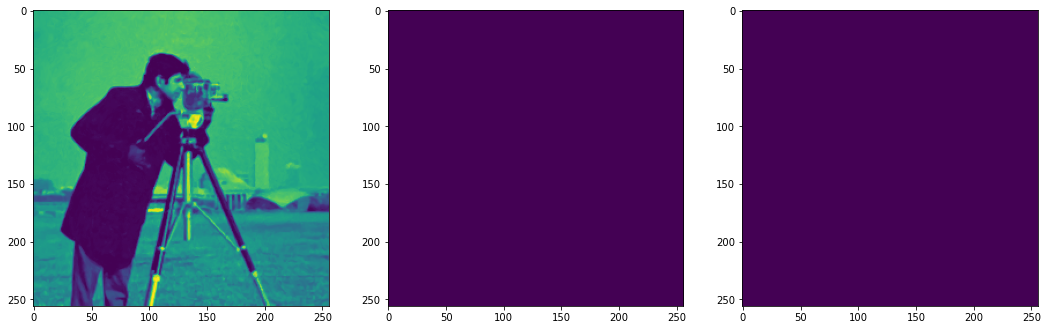

Step: 3200
LOSS{true_stan: 0.029895, weighted_stan: 0.029895}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1441426845.750000, weighted_linear: 1441426845.750000}
LOSS{true_total: 1441426816.000000, weighted_total: 1441426816.000000}


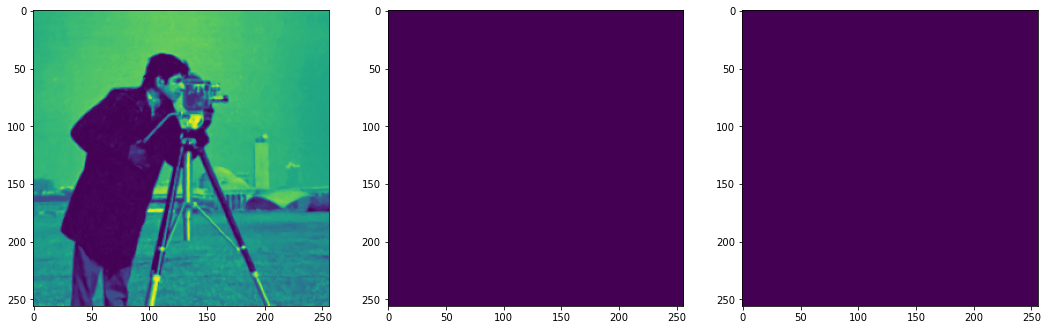

Step: 3300
LOSS{true_stan: 0.044861, weighted_stan: 0.044861}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1441744218.250000, weighted_linear: 1441744218.250000}
LOSS{true_total: 1441744256.000000, weighted_total: 1441744256.000000}


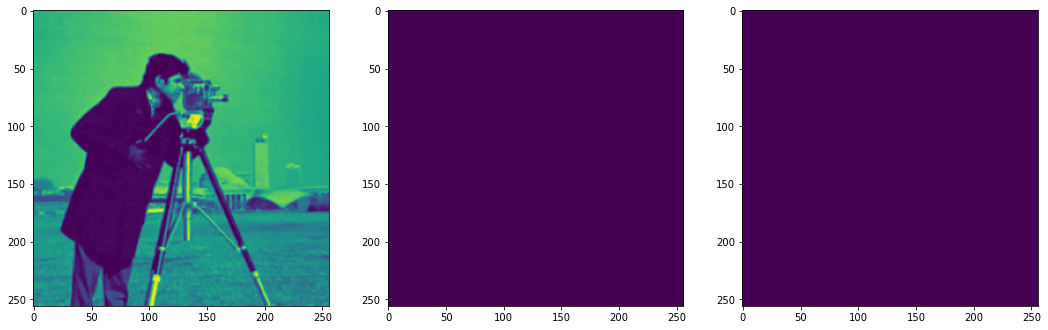

Step: 3400
LOSS{true_stan: 0.043286, weighted_stan: 0.043286}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1448755124.500000, weighted_linear: 1448755124.500000}
LOSS{true_total: 1448755072.000000, weighted_total: 1448755072.000000}


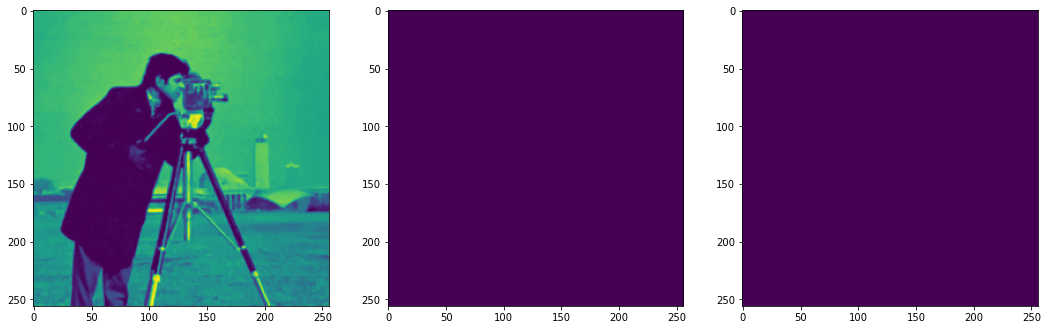

Step: 3500
LOSS{true_stan: 0.043129, weighted_stan: 0.043129}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1447901990.250000, weighted_linear: 1447901990.250000}
LOSS{true_total: 1447901952.000000, weighted_total: 1447901952.000000}


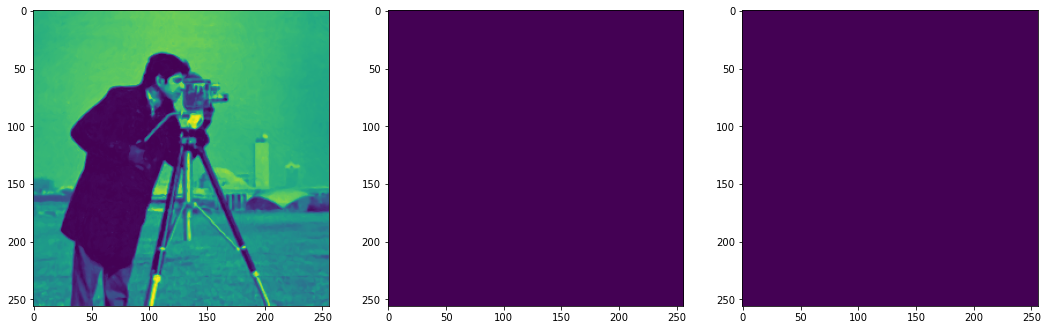

Step: 3600
LOSS{true_stan: 0.017777, weighted_stan: 0.017777}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1449177987.750000, weighted_linear: 1449177987.750000}
LOSS{true_total: 1449177984.000000, weighted_total: 1449177984.000000}


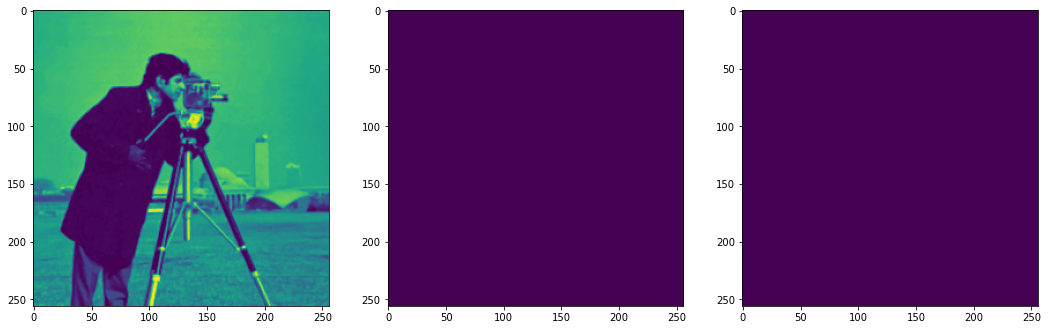

Step: 3700
LOSS{true_stan: 0.020648, weighted_stan: 0.020648}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1451710796.500000, weighted_linear: 1451710796.500000}
LOSS{true_total: 1451710848.000000, weighted_total: 1451710848.000000}


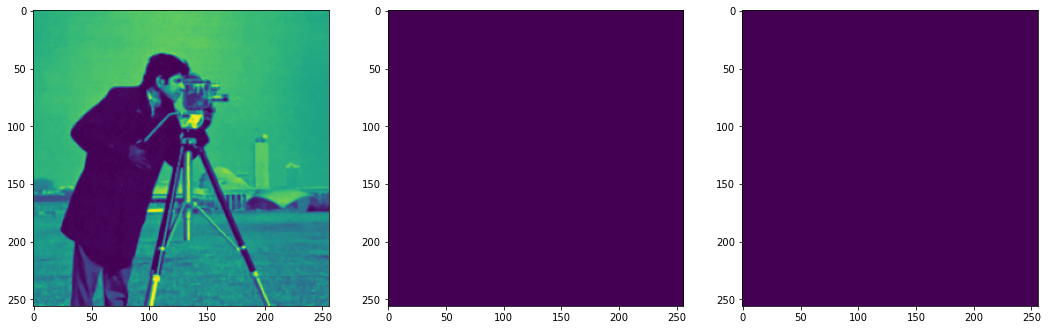

Step: 3800
LOSS{true_stan: 0.027500, weighted_stan: 0.027500}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1455269028.250000, weighted_linear: 1455269028.250000}
LOSS{true_total: 1455268992.000000, weighted_total: 1455268992.000000}


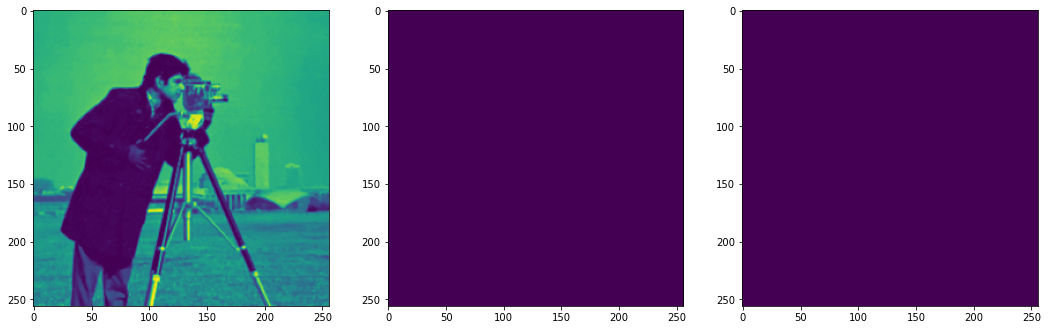

Step: 3900
LOSS{true_stan: 0.034076, weighted_stan: 0.034076}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1456926492.750000, weighted_linear: 1456926492.750000}
LOSS{true_total: 1456926464.000000, weighted_total: 1456926464.000000}


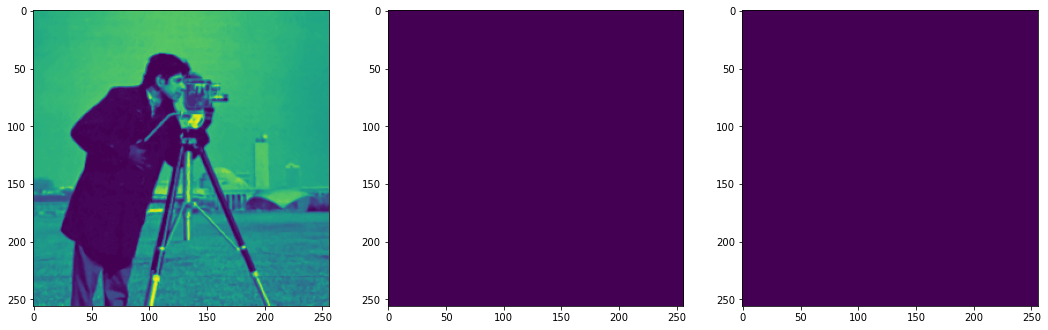

Step: 4000
LOSS{true_stan: 0.013289, weighted_stan: 0.013289}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1456489596.250000, weighted_linear: 1456489596.250000}
LOSS{true_total: 1456489600.000000, weighted_total: 1456489600.000000}


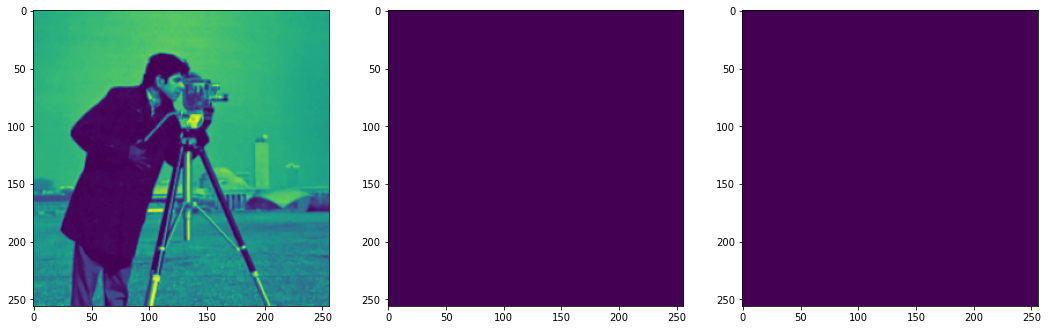

Step: 4100
LOSS{true_stan: 0.007503, weighted_stan: 0.007503}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1466618393.750000, weighted_linear: 1466618393.750000}
LOSS{true_total: 1466618368.000000, weighted_total: 1466618368.000000}


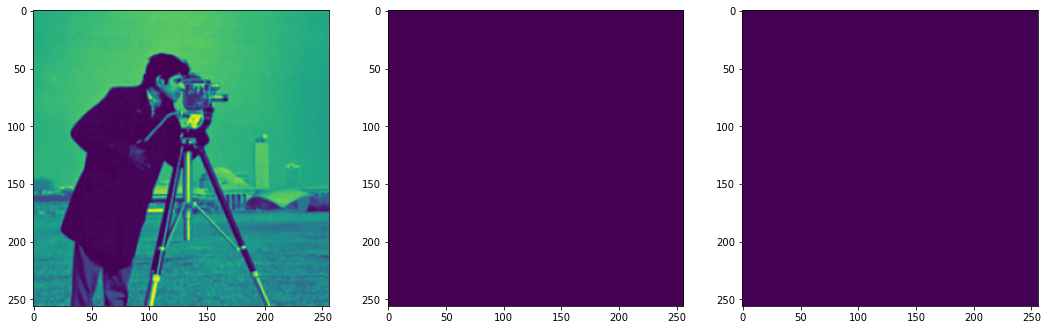

Step: 4200
LOSS{true_stan: 0.029483, weighted_stan: 0.029483}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1464406361.250000, weighted_linear: 1464406361.250000}
LOSS{true_total: 1464406400.000000, weighted_total: 1464406400.000000}


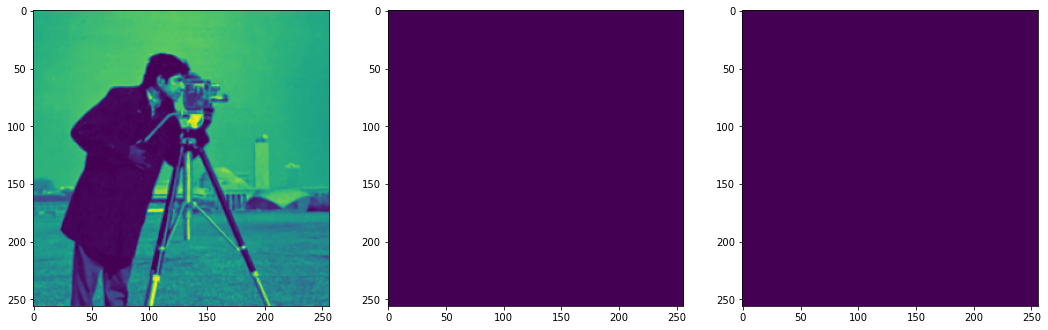

Step: 4300
LOSS{true_stan: 0.011558, weighted_stan: 0.011558}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1467375340.000000, weighted_linear: 1467375340.000000}
LOSS{true_total: 1467375360.000000, weighted_total: 1467375360.000000}


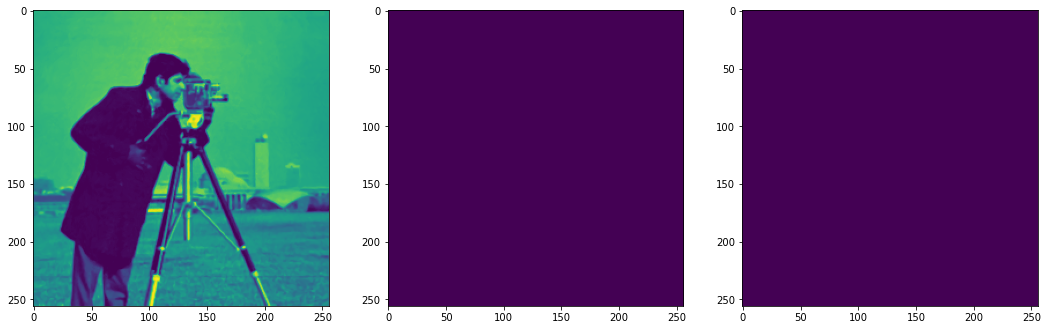

Step: 4400
LOSS{true_stan: 0.031083, weighted_stan: 0.031083}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1467519828.750000, weighted_linear: 1467519828.750000}
LOSS{true_total: 1467519872.000000, weighted_total: 1467519872.000000}


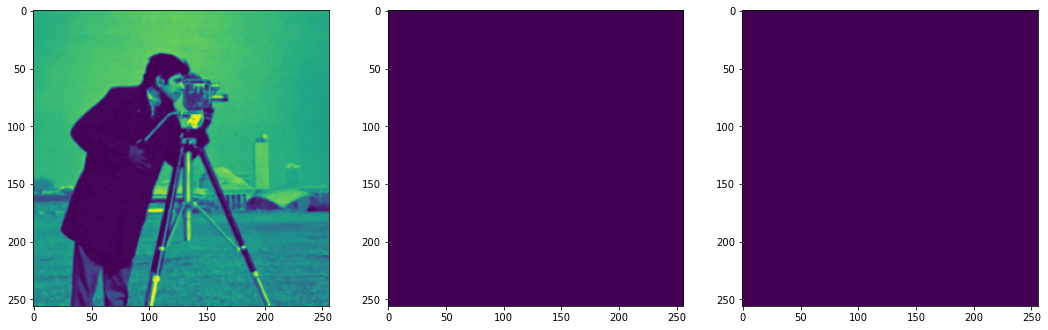

Step: 4500
LOSS{true_stan: 0.044514, weighted_stan: 0.044514}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1470862373.500000, weighted_linear: 1470862373.500000}
LOSS{true_total: 1470862336.000000, weighted_total: 1470862336.000000}


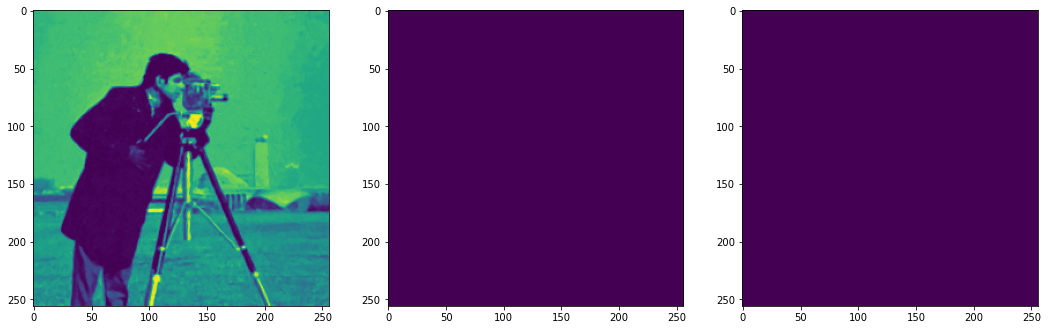

Step: 4600
LOSS{true_stan: 0.045548, weighted_stan: 0.045548}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1472532208.250000, weighted_linear: 1472532208.250000}
LOSS{true_total: 1472532224.000000, weighted_total: 1472532224.000000}


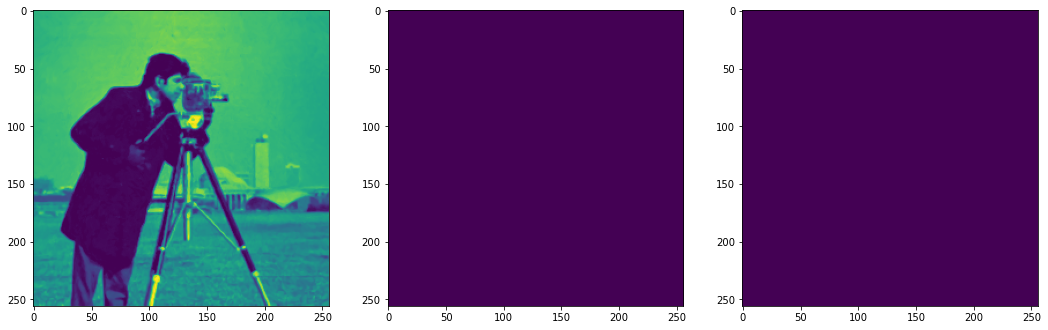

Step: 4700
LOSS{true_stan: 0.014215, weighted_stan: 0.014215}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1478444655.500000, weighted_linear: 1478444655.500000}
LOSS{true_total: 1478444672.000000, weighted_total: 1478444672.000000}


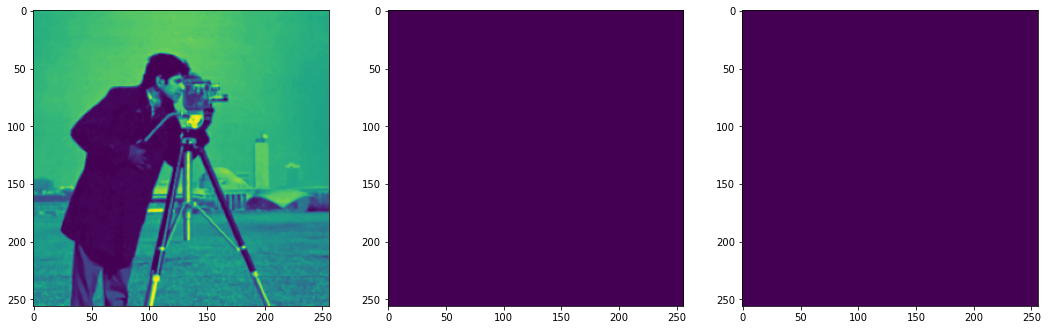

Step: 4800
LOSS{true_stan: 0.007152, weighted_stan: 0.007152}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1485636710.500000, weighted_linear: 1485636710.500000}
LOSS{true_total: 1485636736.000000, weighted_total: 1485636736.000000}


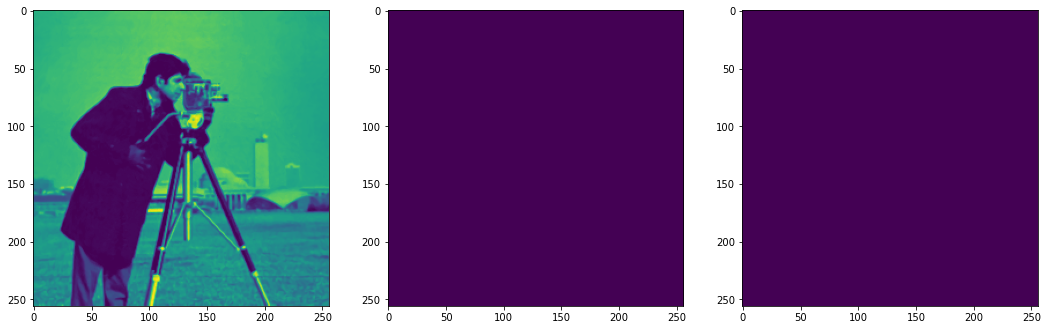

Step: 4900
LOSS{true_stan: 0.037324, weighted_stan: 0.037324}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1486874650.000000, weighted_linear: 1486874650.000000}
LOSS{true_total: 1486874624.000000, weighted_total: 1486874624.000000}


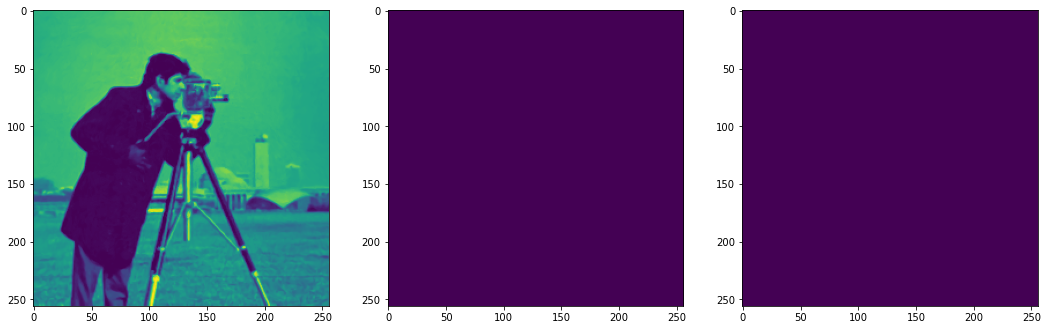

Step: 5000
LOSS{true_stan: 0.008420, weighted_stan: 0.008420}
LOSS{true_grad: 0.000000, weighted_grad: 0.000000}
LOSS{true_lapl: 0.000000, weighted_lapl: 0.000000}
LOSS{true_weight: 0.000000, weighted_weight: 0.000000}
LOSS{true_linear: 1488019021.750000, weighted_linear: 1488019021.750000}
LOSS{true_total: 1488019072.000000, weighted_total: 1488019072.000000}


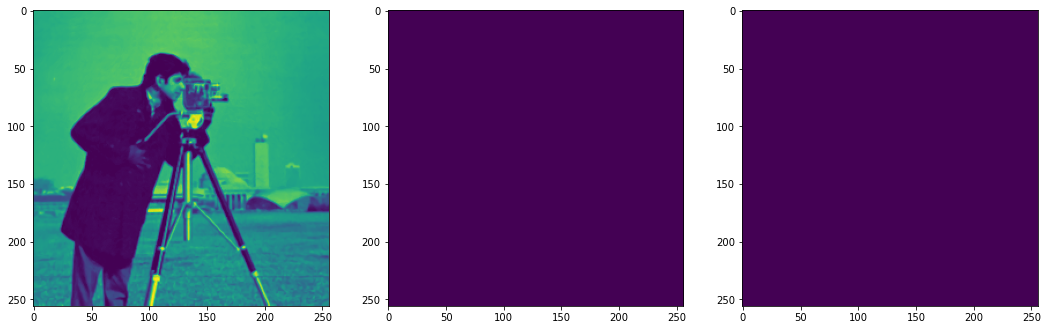

Difference between target and recreation


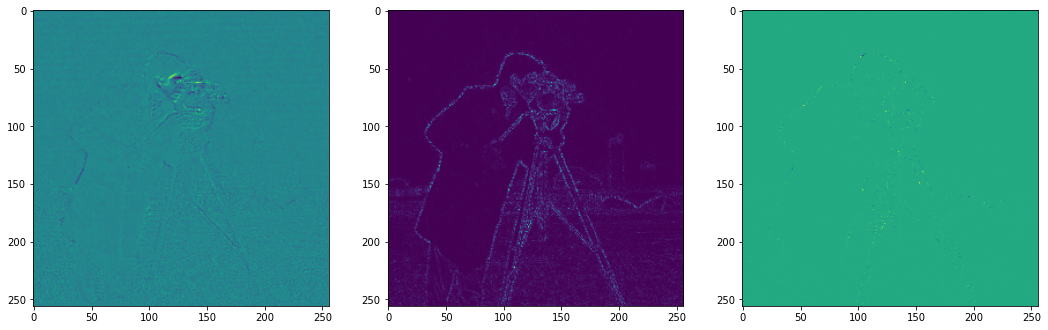

In [10]:
total_steps = 5000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 100

optim = torch.optim.Adam(lr=1e-4, params=img_exp_siren.parameters())

ema = EMA_params(img_exp_siren.parameters(), alpha = 0.01)
perturb = perturb_params(img_exp_siren.parameters())
shift_loss = shift_loss_params(img_exp_siren.parameters())

num_params = shift_loss.num_params()

complete_model_input, complete_ground_truth = cameraman_poisson.complete()
print("complete_model_input: ", complete_model_input.size())
for k, v in complete_ground_truth.items():
    print("complete_ground_truth[", k, "]: ", v.size())

fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(complete_ground_truth['pixels'].clone().cpu().view(256,256).detach().numpy())
axes[1].imshow(complete_ground_truth['grads'].clone().norm(dim=-1).cpu().view(256,256).detach().numpy())
axes[2].imshow(complete_ground_truth['laplace'].clone().cpu().view(256,256).detach().numpy())
plt.show()

complete_model_input = complete_model_input.cuda()
for k in complete_ground_truth:
    complete_ground_truth[k] = complete_ground_truth[k].cuda()
    
complete_model = {}
complete_model['pixels']  = torch.zeros((65536), requires_grad=False).cuda()
complete_model['grads']   = torch.zeros((65536, 2), requires_grad=False).cuda()
complete_model['laplace'] = torch.zeros((256, 256), requires_grad=False).cuda()

stan = True
grad = False
lapl = False
inner_linear_output = linear_output

#loss_manager = 0.

model_output = 0.
img_grad = 0.
img_laplacian = 0.

img_exp_siren.train()

for step in range(total_steps+1):
    
    dictionary_terms = {'stan', 'grad', 'lapl', 'weight', 'linear', 'total'}
    iter_loss = {'stan': 0., 'grad': 0., 'lapl': 0., 'weight' : 0., 'linear' : 0., 'total' : 0.}
    iter_loss_unweighted = {'stan': 0., 'grad': 0., 'lapl': 0., 'weight' : 0., 'linear' : 0., 'total' : 0.}
    
    alpha = {'stan': 1., 'grad':1.0e-4, 'lapl':1., 'weight':1.0e-2, 'linear':1.}
    
    for model_input, ground_truth in iter(dataloader):
        model_input = model_input.cuda()
        for k in ground_truth:
            ground_truth[k] = ground_truth[k].cuda()
        
        if inner_linear_output:
            model_output, model_gradient, model_laplacian, inner_linears = img_exp_siren(model_input, grad, lapl)
        else:
            model_output, model_gradient, model_laplacian = img_exp_siren(model_input, grad, lapl)
        
        batch_loss = {'total':0.}
        batch_loss['stan'], batch_loss['grad'], batch_loss['lapl'] = total_mse(ground_truth, model_output, 
                                                                      model_gradient, model_laplacian)
        batch_loss['weight'] = shift_loss.get_loss()
        batch_loss['linear'] = sum([torch.sum(torch.square(linear)).item() for linear in inner_linears]) if inner_linear_output else 0.

        for k in dictionary_terms:
            if k != 'total':
                iter_loss_unweighted[k] += batch_loss[k]
                batch_loss[k] *= alpha[k]
                batch_loss['total'] += batch_loss[k]
                iter_loss[k] += batch_loss[k]
        
        optim.zero_grad()
        batch_loss['total'].backward()
        optim.step()
    
        ema.update()
        ema.copy_from_ma()
    
        perturb.perturb()
    
    iter_loss_unweighted['total'] = sum([iter_loss_unweighted[k] for k in dictionary_terms if k != 'total'])
    iter_loss['total'] = sum([iter_loss[k] for k in dictionary_terms if k != 'total'])
    
    if not step % steps_til_summary:
        
        print("Step: %d" % (step))
        for k in iter_loss:
            print("LOSS{true_%s: %0.6f, weighted_%s: %0.6f}" % (k, iter_loss_unweighted[k], k, iter_loss[k]))

        img_exp_siren.eval()
        if inner_linear_output:
            complete_model_output, complete_model_gradient, complete_model_laplacian, _ = img_exp_siren(complete_model_input, grad, lapl)
        else:
            complete_model_output, complete_model_gradient, complete_model_laplacian = img_exp_siren(complete_model_input, grad, lapl)
        img_exp_siren.train()
        
        if not grad:
            complete_model_gradient = complete_model['grads']
        if not lapl:
            complete_model_laplacian = complete_model['laplace']
        
        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(complete_model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(complete_model_gradient.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(complete_model_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()


img_exp_siren.eval()
if inner_linear_output:
    pixels, grads, lapl, _ = img_exp_siren(complete_model_input, True, True)
else:
    pixels, grads, lapl = img_exp_siren(complete_model_input, True, True)
    
print("Difference between target and recreation")
fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow((pixels - complete_ground_truth['pixels']).cpu().view(256,256).detach().numpy())
axes[1].imshow((grads - complete_ground_truth['grads']).norm(dim=-1).cpu().view(256,256).detach().numpy())
axes[2].imshow((lapl.view(256, 256) - complete_ground_truth['laplace']).cpu().view(256,256).detach().numpy())
plt.show()

In [11]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def example(start = 0.0, end = 1.0):
    complete_model_input = get_mgrid(256, 2, start, end).cuda()

    img_exp_siren.eval()
    if inner_linear_output:
        pixels, grads, lapl, _ = img_exp_siren(complete_model_input, True, True)
    else:
        pixels, grads, lapl = img_exp_siren(complete_model_input, True, True)
    
    print("Recreation on desired scale of %f to %f" % (start, end))
    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow((pixels).cpu().view(256,256).detach().numpy())
    axes[1].imshow((grads).norm(dim=-1).cpu().view(256,256).detach().numpy())
    axes[2].imshow((lapl).cpu().view(256,256).detach().numpy())
    plt.show()
    
interact(example, start = widgets.FloatSlider(min=-0.5, max=1.5), end = widgets.FloatSlider(min=-0.5, max=1.5))

interactive(children=(FloatSlider(value=0.0, description='start', max=1.5, min=-0.5), FloatSlider(value=0.0, d…

<function __main__.example(start=0.0, end=1.0)>